## Imports

You need `sklearn-pandas` which can be installed by uncommenting the following block

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper 
from pycox.evaluation import EvalSurv
from pycox.models import CoxTime
import pandas as pd
import torch # For building the networks 
from sklearn.model_selection import KFold, GridSearchCV
from estimators import CoxTimeEstimator
import torchtuples as tt # Some useful functions
from collections import defaultdict

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Hyper-parameters
test_size = 0.2
train_size = 0.8
assert test_size + train_size == 1, "total size is not equal to 1"

In [4]:
# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed);

## Dataset

We load data from an Iranian Institution

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

In [5]:
train_dataset_fp ='finaldata-June26.csv'
df = pd.read_csv(train_dataset_fp)
df.head(100)

,event,time,diagnosic-age,edjucation,marital-status,G,AB,BF,FH,Surgery,T,N,stage,Path,Grade,LVI,hormone subgroup,CT,RT,HT
0,0,334.2,46,2,2,2,1,1,0,2,1,2,3,1,2,0,2,1,1,1
1,0,328.9,35,1,2,2,0,1,0,1,3,0,2,1,2,0,4,1,1,1
2,0,310.4,41,2,2,2,0,1,0,2,1,2,3,1,2,1,2,1,1,1
3,0,309.7,48,2,2,1,0,1,0,2,2,0,2,1,2,0,2,1,0,1
4,1,299.6,47,4,2,3,0,2,2,2,2,0,2,1,2,0,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,211.1,47,2,2,2,1,1,1,2,1,0,1,1,3,0,2,0,0,1
96,0,210.8,36,1,2,0,0,0,0,2,1,0,1,1,1,0,2,1,1,1
97,0,210.6,54,1,2,3,1,1,2,2,2,0,2,1,2,0,2,0,1,1
98,0,208.9,41,1,2,1,0,1,0,2,2,0,2,1,2,0,4,1,1,1


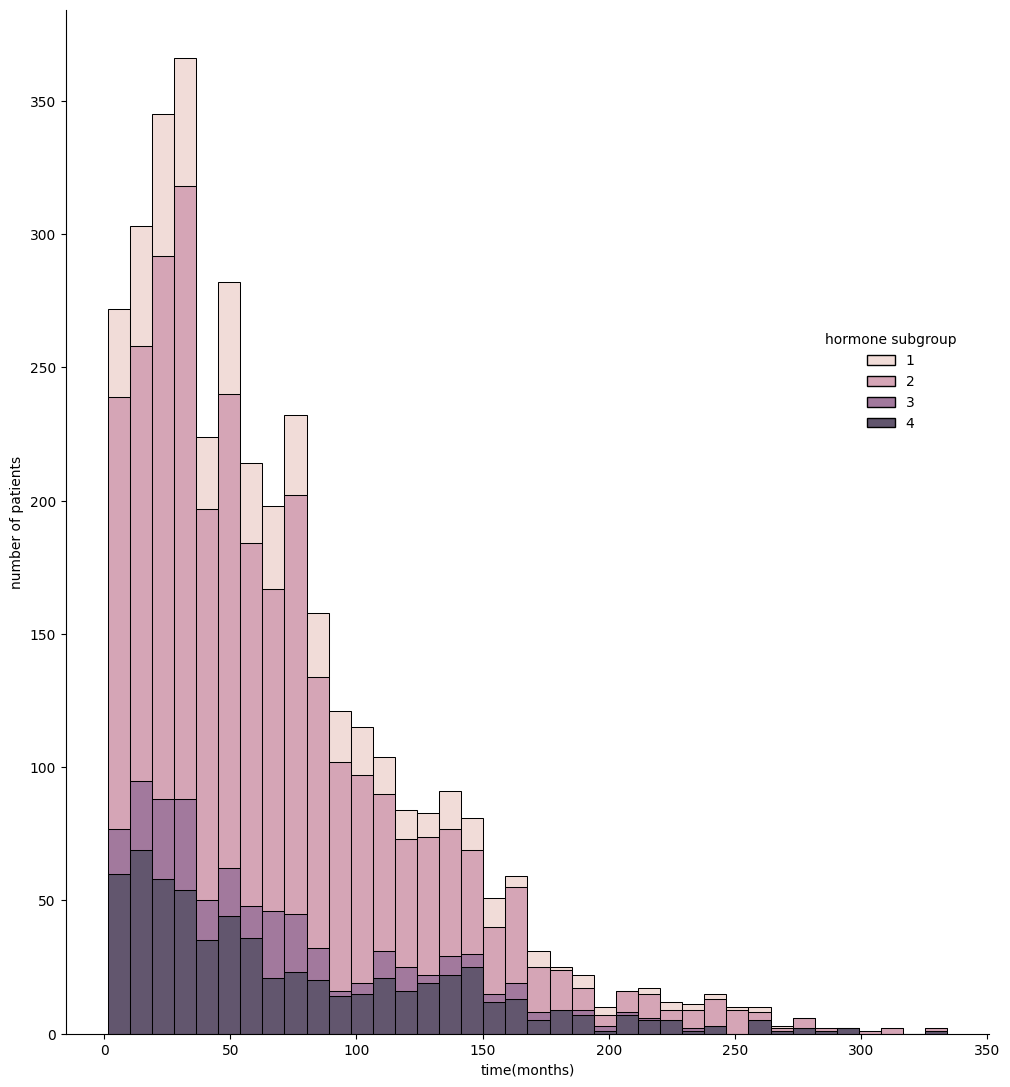

In [6]:
import seaborn as sns

s = sns.displot(df, x="time", hue="hormone subgroup", multiple="stack")
s.set(xlabel='time(months)', ylabel='number of patients')
plt.gcf().set_size_inches(15, 12)
sns.move_legend(s, "center", bbox_to_anchor=(.66, .66))  

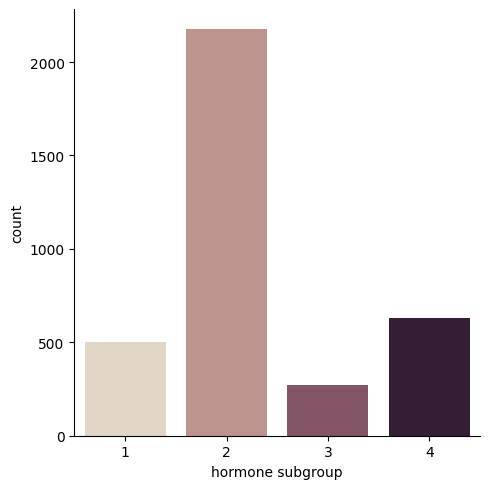

In [7]:
sns.catplot(x="hormone subgroup", kind="count", palette="ch:.25", data=df);

<AxesSubplot: xlabel='count', ylabel='hormone subgroup'>

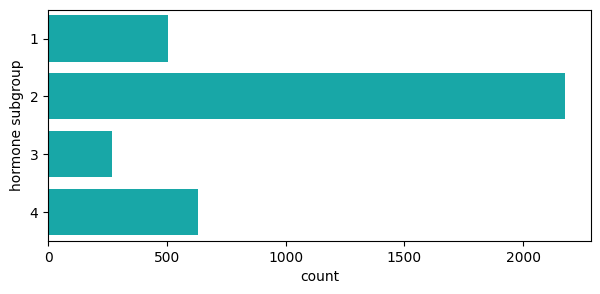

In [8]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="hormone subgroup", data=df, color="c")

In [9]:
df_train, df_test = train_test_split(df, test_size=test_size, random_state=seed, stratify=df["hormone subgroup"])

## Feature transforms

The METABRIC dataset has  9 covariates: `x0, ..., x8`.
We will standardize the 5 numerical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

Here we use the `sklearn_pandas.DataFrameMapper` to make feature mappers, but this has nothing to do the the `pycox` package.

In [10]:
cols_standardize = ['diagnosic-age',
                    'edjucation', 
                    'G',
                    'BF',
                    'FH',
                    'T',
                    'N',
                    'stage',
                    'Grade',
                    'CT','RT','hormone subgroup']
cols_leave = ['marital-status', 'AB', 'Path', 'LVI', 'Surgery', 'HT']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [11]:
# apply scalar transformation!
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [12]:
# Checking the distribution of `hormone subgroup`
feature_index = 11 # hormone subgroup

def get_feature_distribution(feature_index, dataset):
    filtered_individuals = defaultdict(list)
    dataset_reverse = standardize[feature_index][1].inverse_transform(dataset)

    for i in range(len(dataset)):
        individual = dataset_reverse[i]
        filtered_individuals[int(individual[feature_index])].append(i)
    print(sorted([(k, len(v)) for k, v in filtered_individuals.items()]))
    return filtered_individuals
get_feature_distribution(feature_index, x_test);
get_feature_distribution(feature_index, x_train);

[(1, 101), (2, 435), (3, 54), (4, 126)]
[(1, 402), (2, 1740), (3, 216), (4, 506)]


## Label transforms

The survival methods require individual label transforms, so we have included a proposed `label_transform` for each method.
For most of them the `label_transform` is just a shorthand for the class `pycox.preprocessing.label_transforms.LabTransDiscreteTime`.

In [13]:
# events!
np.unique(df['event'], return_counts=True)

(array([0, 1], dtype=int64), array([3146,  434], dtype=int64))

In [14]:
label_translator = CoxTime.label_transform()
get_features = lambda df: (df['time'].values, df['event'].values)
label_translator.fit_transform(*get_features(df_train))

(array([-0.7820541 , -0.34317163, -0.8591799 , ..., -0.8775432 ,
         0.8853323 ,  1.7263708 ], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [15]:
# labtrans = CoxTime.label_transform()
# get_target = lambda df: (df['time'].values, df['event'].values)
# y_train = labtrans.fit_transform(*get_target(df_train))
# y_val = labtrans.transform(*get_target(df_val))
# durations_test, events_test = get_target(df_test)

# K-Fold

In [16]:
params = {  # search params
        'learning_rate': [0.1, 0.01, 0.001],
        'num_nodes': [[32, 32], [32, 64], [32, 64, 128], [32, 64, 128, 256], [32, 64, 128, 256, 512]],
        'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'batch_size': [256],
    }

cv = 5

In [17]:
estimator = CoxTimeEstimator(label_translator, x_train.shape[1])
gs = GridSearchCV(estimator, params, refit=True, cv=KFold(n_splits=cv), verbose=1, n_jobs=1)

In [18]:
stack = lambda duration, event:np.hstack([duration.reshape((-1, 1)), event.reshape((-1, 1))])
y_train = stack(*get_features(df_train))

In [19]:
gs.fit(x_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=CoxTimeEstimator(in_features=18,
                                        label_translator=<pycox.preprocessing.label_transforms.LabTransCoxTime object at 0x0000022038CF4DF0>),
             n_jobs=1,
             param_grid={'batch_size': [256],
                         'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'num_nodes': [[32, 32], [32, 64], [32, 64, 128],
                                       [32, 64, 128, 256],
                                       [32, 64, 128, 256, 512]]},
             verbose=1)

In [20]:
print(gs.best_score_, gs.best_params_)

0.7798756525621332 {'batch_size': 256, 'dropout': 0.1, 'learning_rate': 0.1, 'num_nodes': [32, 64]}


In [21]:
durations_test, events_test = get_features(df_test)
gs.score(x_test, np.hstack([durations_test.reshape((-1, 1)), events_test.reshape((-1, 1))]))

0.7490193001726032

In [22]:
estimator = CoxTimeEstimator(label_translator, x_train.shape[1], **gs.best_params_)

In [23]:
estimator.fit(x_train, y_train)

CoxTimeEstimator(dropout=0.1, in_features=18,
                 label_translator=<pycox.preprocessing.label_transforms.LabTransCoxTime object at 0x0000022038CF4DF0>,
                 learning_rate=0.1, num_nodes=[32, 64])

In [24]:
estimator.score_split(x_test, durations_test, events_test)

0.7343480307547466

In [25]:
model = estimator.model
log = model.log
model.net

MLPVanillaCoxTime(
  (net): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=19, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=64, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (2): Linear(in_features=64, out_features=1, bias=False)
    )
  )
)

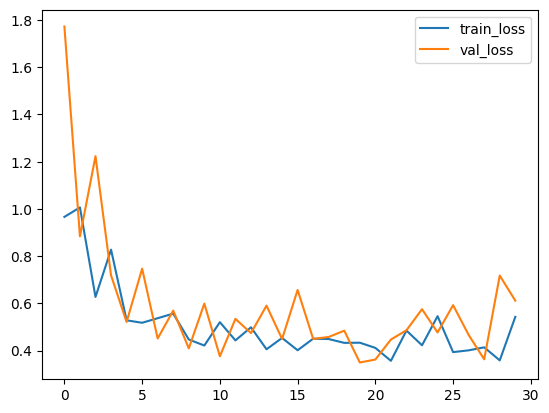

In [26]:
log.plot();

Next, we set the `batch_size` and the number of training `epochs`.

We also include the `EarlyStopping` callback to stop training when the validation loss stops improving.

In [27]:
log.to_pandas().val_loss.min()

0.3495159447193146

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

In [28]:
surv = model.predict_surv_df(x_test)
surv
# columns are sample indices, values are the probability of the events

,0,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
1.6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000
2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000
2.3,0.999965,0.999958,0.999421,0.999475,0.999996,0.999833,0.997999,0.998612,0.999926,0.999639,...,0.999940,0.999019,0.999409,0.999879,0.999772,0.999684,9.986517e-01,0.999949,0.999522,0.999980
3.0,0.999931,0.999915,0.998840,0.998952,0.999991,0.999665,0.996003,0.997227,0.999853,0.999277,...,0.999879,0.998036,0.998814,0.999758,0.999544,0.999367,9.973039e-01,0.999897,0.999042,0.999960
3.3,0.999931,0.999915,0.998840,0.998952,0.999991,0.999665,0.996003,0.997227,0.999853,0.999277,...,0.999879,0.998036,0.998814,0.999758,0.999544,0.999367,9.973039e-01,0.999897,0.999042,0.999960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294.0,0.822728,0.849358,0.078478,0.562648,0.877519,0.598410,0.094026,0.375343,0.439289,0.396990,...,0.804995,0.056386,0.112876,0.748393,0.717980,0.600649,1.650834e-03,0.515342,0.230269,0.470470
299.6,0.560449,0.746046,0.003129,0.433270,0.563845,0.436289,0.032435,0.306214,0.120675,0.141746,...,0.707118,0.004356,0.013819,0.616036,0.608994,0.480806,6.960899e-08,0.168502,0.109490,0.127017
309.7,0.560449,0.746046,0.003129,0.433270,0.563845,0.436289,0.032435,0.306214,0.120675,0.141746,...,0.707118,0.004356,0.013819,0.616036,0.608994,0.480806,6.960899e-08,0.168502,0.109490,0.127017
328.9,0.560449,0.746046,0.003129,0.433270,0.563845,0.436289,0.032435,0.306214,0.120675,0.141746,...,0.707118,0.004356,0.013819,0.616036,0.608994,0.480806,6.960899e-08,0.168502,0.109490,0.127017


## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [29]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [30]:
ev.concordance_td('adj_antolini')

0.7343480307547466

#### Brier Score

We can plot the the [IPCW Brier score](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) for a given set of times.
Here we just use 100 time-points between the min and max duration in the test set.
Note that the score becomes unstable for the highest times. It is therefore common to disregard the rightmost part of the graph.

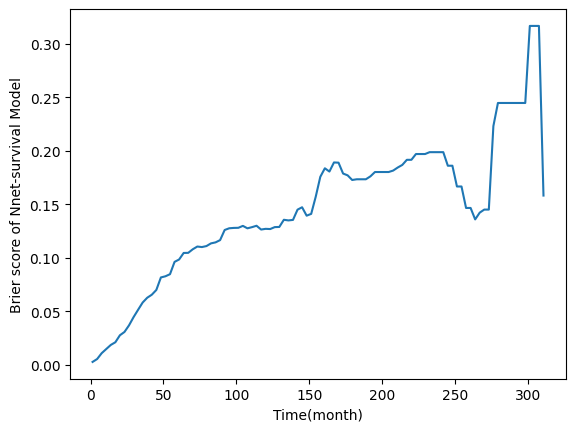

In [31]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score of Nnet-survival Model')
_ = plt.xlabel('Time(month)')

#### Negative binomial log-likelihood

In a similar manner, we can plot the the [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

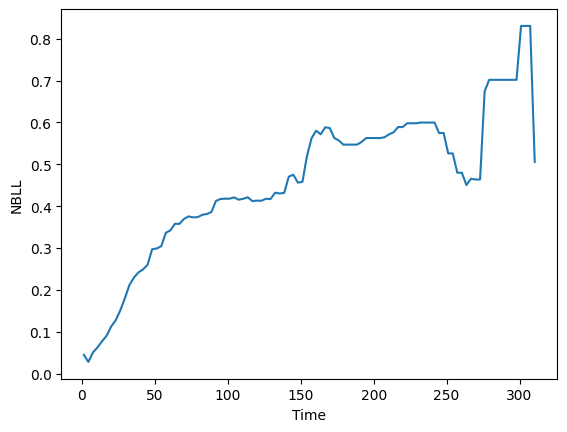

In [32]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). In practice this is done by numerical integration over a defined `time_grid`.

In [33]:
ev.integrated_brier_score(time_grid) 

0.14638876777665719

In [34]:
ev.integrated_nbll(time_grid) 

0.4602016703248651

*_:-)_*